In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
sns.set();

### Generate data

In [4]:
# Generate sample data
rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.

# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations
X_mean = X.mean()


### Helpers

In [20]:
def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6,
                       color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')


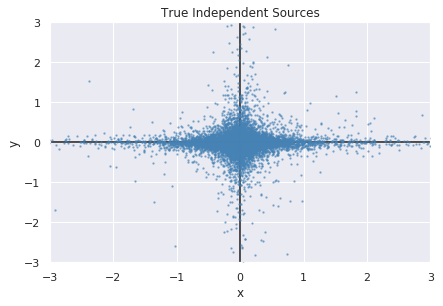

In [23]:
plt.figure(figsize=(15,15))
plt.subplot(3, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources');

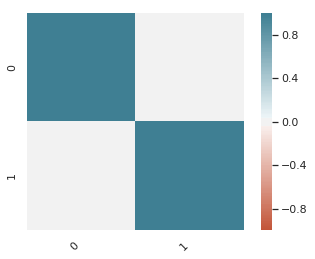

In [25]:
corr = np.corrcoef(S.T)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

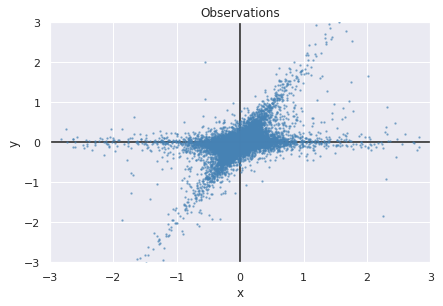

In [24]:
plt.figure(figsize=(15,15))
plt.subplot(3, 2, 2)
plot_samples(X / X.std())
plt.title('Observations')
plt.show();

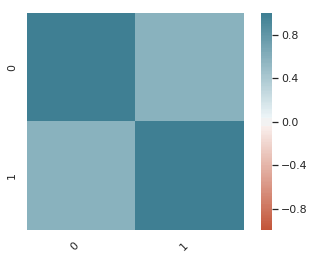

In [26]:
corr = np.corrcoef(X.T)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

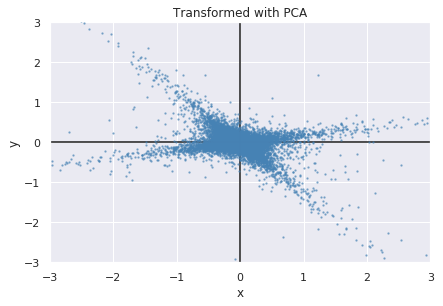

In [17]:
pca = PCA(n_components=2)
X_tr_pca = pca.fit_transform(X)
plt.figure(figsize=(15,15))
plt.subplot(3, 2, 1)
plot_samples(X_tr_pca / X_tr_pca.std())
plt.title('Transformed with PCA');

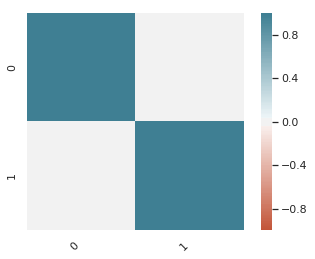

In [18]:
corr = np.corrcoef(X_tr_pca.T)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### ICA implementation

In [31]:
class ICA():
    """
    Independent Component Analysis
    
    """

    def __init__(self, n_components, lr, num_epochs,method="simgoid"):
        """
        Init function
        
        :param n_components: reduced data dimension(int)
        :param lr: learning_rate(float)
        :param num_epochs: number off epochs for fit(int)
        :param mean: mean off data set 
        :param W: If X = As, then W = A^(-1), W is n_components*samples_number matrix 
        """
        
        self.n_components = n_components
        self.lr = lr
        self.num_epochs = num_epochs
        self.method = method
        self.mean = None
        self.W = None
    
    def to_zero_mean(self,X):
        """
        This method compute the mean of X, and return transformed data
        
        :param X(input data): m*n numpy array 
        :return X-X_mean()
        """
        
        self.mean = X.mean()
        return X - X.mean()
    

    def g(self, x):
        """
        Simple g function
        :param x: np.array
        :return: g(x)
        """
        if self.method == "sigmoid":   
            return 1.0 / (1 + np.exp(-1 * x))
        
    
    def log_likelihood(self,X,W_curr):
        """
        Loss function
        param:X our data(np.array)
        param:W_curr current W matrix(np.array)
        """
        
        loss = 0
        X = self.to_zero_mean(X)

        for i in range(X.shape[1]):
            loss += np.sum(np.log(self.g(np.dot(W_curr,X[:,i]))) + np.log(np.linalg.norm(W_curr)))
            
        return loss
        
    def fit(self, X):
        """
        Main fit function
        Calculate and update W matrix with gradient descent
        
        :param X: our data
        :return: W
        """
        
        W_curr = np.eye(self.n_components,self.n_components)
        X = self.to_zero_mean(X)
        if self.method == "sigmoid":
            
            for epoch in range(self.num_epochs):
                for step in range(X.shape[1]):
                    
                    idx = np.random.randint(X.shape[1],size=1)
                    temp = self.g(np.dot(W_curr,X[:,idx]))
                    current_sum = self.lr*(np.dot((1-2*temp),X[:,idx].T) + np.linalg.inv(W_curr.T))
                    W_curr += current_sum                    
            
            self.W = W_curr
            
        elif self.method == "tanh":
            pass
        
    def fit_transform(self, X):
        """
        Fit and transform data set
        :param X: our data
        :return: transformed matrix
        """
        self.fit(X)
        return np.dot(self.W,X)
    

In [47]:
ica = ICA(2,0.0001,3,"sigmoid")
S_ = ica.fit_transform(X.T)

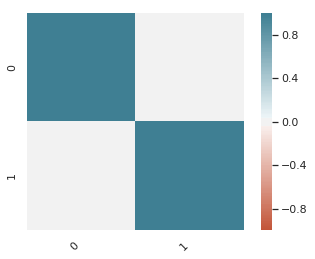

In [48]:
corr = np.corrcoef(S_)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

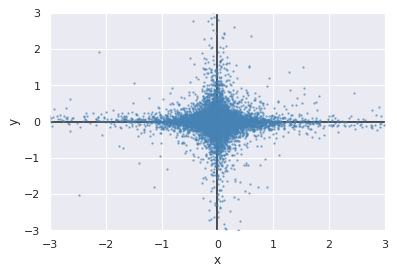

In [49]:
plot_samples(S_.T/S_.T.std(axis=0))